In [1]:
# %%
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score
)


In [2]:

# =====================================================
# Utility Functions
# =====================================================

def segment_signal(signal, segment_length=4096):
    """
    Segment a 1-minute vibration signal into fixed-length sub-segments.
    
    Args:
        signal (np.array): Input 1D vibration signal.
        segment_length (int): Desired length of each segment.
    
    Returns:
        np.array: Segmented signals.
    """
    n_segments = len(signal) // segment_length
    if len(signal) % segment_length != 0:
        print(f"[Warning] Signal length {len(signal)} cannot be evenly divided by {segment_length}")
    
    segments = []
    for i in range(n_segments):
        start = i * segment_length
        end = start + segment_length
        segments.append(signal[start:end])
    
    return np.array(segments)


def load_dataset(data_type='original'):
    """
    Load vibration data from NASA bearing dataset (.mat file).
    
    Args:
        data_type (str): 'original' or 'denoised'.
    
    Returns:
        X (np.array): Feature matrix of segmented signals.
        y (np.array): Corresponding labels.
    """
    mat_data = sio.loadmat('NASA改好了.mat')
    
    if data_type == 'original':
        data_keys = ['cage_original', 'noramal_original', 'outer_original']
        print("Using original data.")
    elif data_type == 'denoised':
        data_keys = ['cage_denoised', 'noramal_denoised', 'outer_denoised']
        print("Using denoised data.")
    else:
        raise ValueError("Invalid data type. Choose 'original' or 'denoised'.")

    labels = [0, 1, 2]  # 0: cage, 1: normal, 2: outer
    
    all_data, all_labels = [], []
    for key, label in zip(data_keys, labels):
        if key in mat_data:
            data = mat_data[key]
            print(f"Loading {key}, raw shape: {data.shape}")
            
            if data.shape != (20480, 150):
                print(f"[Warning] {key} shape {data.shape} does not match expected (20480, 150)")
                continue
            
            minute_samples = []
            for minute_idx in range(data.shape[1]):
                signal = data[:, minute_idx]
                sub_segments = segment_signal(signal)
                minute_samples.append(sub_segments)
            
            reshaped = np.array(minute_samples).reshape(-1, 4096)
            print(f"{key} processed: {reshaped.shape[0]} samples, each length {reshaped.shape[1]}")
            
            all_data.append(reshaped)
            all_labels.extend([label] * reshaped.shape[0])
    
    X = np.vstack(all_data)
    y = np.array(all_labels)
    return X, y


def preprocess_data(X, y):
    """
    Normalize and split data into training and testing sets.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=42
    )
    return X_train, X_test, y_train, y_test, scaler


from sklearn.metrics import confusion_matrix

# def plot_confusion_matrix(y_true, y_pred, model_name):
#     """
#     Plot confusion matrix with all classes included.
#     """
#     class_names = ['cage', 'normal', 'outer']
#     cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])  # 🔑 强制包含三类
#     acc = accuracy_score(y_true, y_pred)

#     plt.figure(figsize=(7, 6))
#     sns.heatmap(
#         cm,
#         annot=True,
#         fmt="d",
#         cmap="Blues",
#         cbar=True,
#         linewidths=0.5,
#         linecolor="gray",
#         xticklabels=class_names,
#         yticklabels=class_names,
#         annot_kws={"size": 14, "weight": "bold", "color": "black"}
#     )
#     plt.title(f"{model_name} Confusion Matrix (Accuracy={acc:.2f})", fontsize=14)
#     plt.ylabel("True Label", fontsize=12)
#     plt.xlabel("Predicted Label", fontsize=12)
#     plt.xticks(fontsize=12)
#     plt.yticks(fontsize=12)
#     plt.tight_layout()
#     plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name):
    """Evaluate model performance and print results"""
    print(f"\n{model_name} Model Evaluation:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix', fontsize=16)  # 增大标题字体
    plt.colorbar()
    classes = ['cage', 'normal', 'outer']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)  # 增大x轴刻度字体
    plt.yticks(tick_marks, classes, fontsize=14)  # 增大y轴刻度字体
    
    # Annotate values on the confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=12)  # 增大矩阵内文本字体
    
    plt.ylabel('True Label', fontsize=14)  # 增大y轴标签字体
    plt.xlabel('Predicted Label', fontsize=14)  # 增大x轴标签字体
    plt.tight_layout()
    plt.show()


    


def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate and display performance of the model.
    """
    print(f"\n=== {model_name} Evaluation ===")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['cage', 'normal', 'outer']))
    plot_confusion_matrix(y_true, y_pred, model_name)


# =====================================================
# Model Training
# =====================================================

def train_svm_classifier(X_train, X_test, y_train, y_test):
    """
    Train SVM classifier and evaluate performance.
    """
    model = svm.NuSVC(kernel='sigmoid')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_model(y_test, y_pred, "SVM")
    return model


def train_rf_classifier(X_train, X_test, y_train, y_test):
    """
    Train Random Forest classifier and evaluate performance.
    """
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_model(y_test, y_pred, "Random Forest")
    return model





Experiment with original data
Using original data.
Loading cage_original, raw shape: (20480, 150)
cage_original processed: 750 samples, each length 4096
Loading noramal_original, raw shape: (20480, 150)
noramal_original processed: 750 samples, each length 4096
Loading outer_original, raw shape: (20480, 150)
outer_original processed: 750 samples, each length 4096
Total samples: 2250, Features: 4096, Classes: 3
Train size: 1800, Test size: 450

=== SVM Evaluation ===
Accuracy: 0.6511
Classification Report:
              precision    recall  f1-score   support

        cage       1.00      1.00      1.00       150
      normal       0.47      0.44      0.46       150
       outer       0.48      0.51      0.50       150

    accuracy                           0.65       450
   macro avg       0.65      0.65      0.65       450
weighted avg       0.65      0.65      0.65       450


SVM Model Evaluation:
Accuracy: 0.6511

Confusion Matrix:
[[150   0   0]
 [  0  66  84]
 [  0  73  77]]

Cl

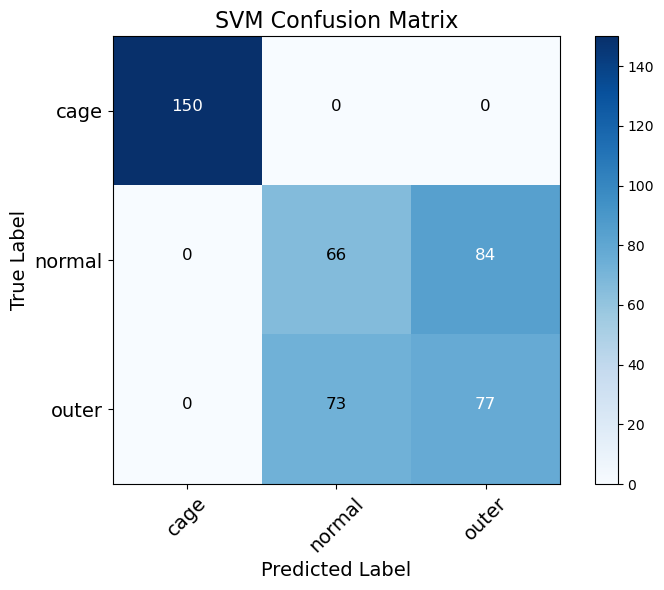

SVM model saved to models/svm_original_model.pkl

=== Random Forest Evaluation ===
Accuracy: 0.9178
Classification Report:
              precision    recall  f1-score   support

        cage       1.00      1.00      1.00       150
      normal       0.85      0.91      0.88       150
       outer       0.91      0.84      0.87       150

    accuracy                           0.92       450
   macro avg       0.92      0.92      0.92       450
weighted avg       0.92      0.92      0.92       450


Random Forest Model Evaluation:
Accuracy: 0.9178

Confusion Matrix:
[[150   0   0]
 [  0 137  13]
 [  0  24 126]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       0.85      0.91      0.88       150
           2       0.91      0.84      0.87       150

    accuracy                           0.92       450
   macro avg       0.92      0.92      0.92       450
weighted avg       0.92      0.

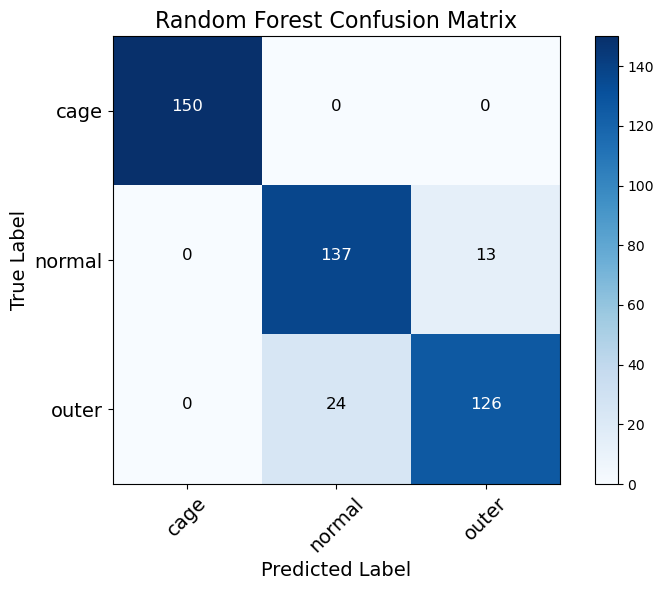

Random Forest model saved to models/rf_original_model.pkl

Experiment with denoised data
Using denoised data.
Loading cage_denoised, raw shape: (20480, 150)
cage_denoised processed: 750 samples, each length 4096
Loading noramal_denoised, raw shape: (20480, 150)
noramal_denoised processed: 750 samples, each length 4096
Loading outer_denoised, raw shape: (20480, 150)
outer_denoised processed: 750 samples, each length 4096
Total samples: 2250, Features: 4096, Classes: 3
Train size: 1800, Test size: 450

=== SVM Evaluation ===
Accuracy: 0.7356
Classification Report:
              precision    recall  f1-score   support

        cage       1.00      0.96      0.98       150
      normal       0.62      0.62      0.62       150
       outer       0.60      0.63      0.61       150

    accuracy                           0.74       450
   macro avg       0.74      0.74      0.74       450
weighted avg       0.74      0.74      0.74       450


SVM Model Evaluation:
Accuracy: 0.7356

Confusion

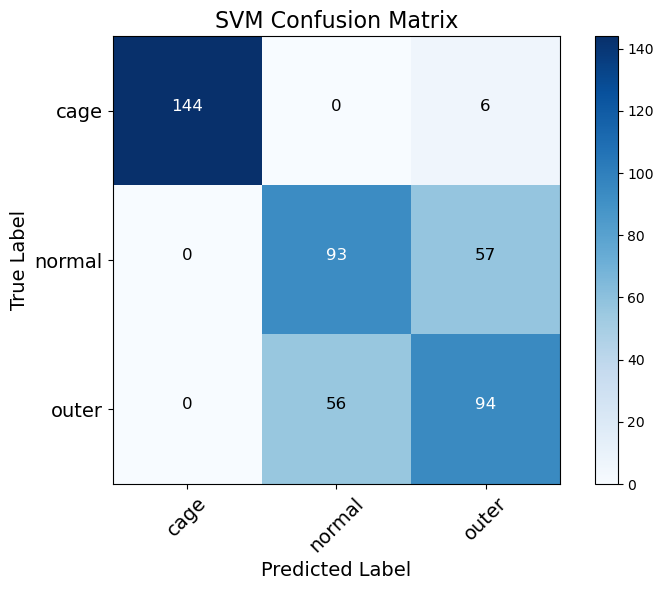

SVM model saved to models/svm_denoised_model.pkl

=== Random Forest Evaluation ===
Accuracy: 0.9800
Classification Report:
              precision    recall  f1-score   support

        cage       1.00      0.96      0.98       150
      normal       0.94      1.00      0.97       150
       outer       1.00      0.98      0.99       150

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450


Random Forest Model Evaluation:
Accuracy: 0.9800

Confusion Matrix:
[[144   6   0]
 [  0 150   0]
 [  0   3 147]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       150
           1       0.94      1.00      0.97       150
           2       1.00      0.98      0.99       150

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.

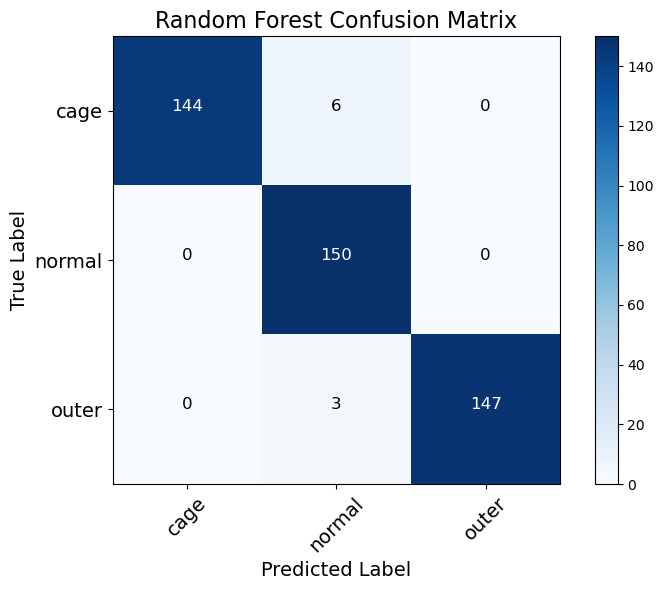

Random Forest model saved to models/rf_denoised_model.pkl


In [3]:
import pickle
import os
import numpy as np

if __name__ == "__main__":
    os.makedirs("models", exist_ok=True)
    
    for dtype in ["original", "denoised"]:
        print("\n" + "="*50)
        print(f"Experiment with {dtype} data")
        print("="*50)
        
        X, y = load_dataset(data_type=dtype)
        print(f"Total samples: {X.shape[0]}, Features: {X.shape[1]}, Classes: {len(np.unique(y))}")
        
        X_train, X_test, y_train, y_test, scaler = preprocess_data(X, y)
        print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
        
        
        svm_model = train_svm_classifier(X_train, X_test, y_train, y_test)
        svm_path = f"models/svm_{dtype}_model.pkl"
        with open(svm_path, 'wb') as f:
            pickle.dump(svm_model, f)
        print(f"SVM model saved to {svm_path}")
        
        rf_model = train_rf_classifier(X_train, X_test, y_train, y_test)
        rf_path = f"models/rf_{dtype}_model.pkl"
        with open(rf_path, 'wb') as f:
            pickle.dump(rf_model, f)
        print(f"Random Forest model saved to {rf_path}")
    